# imorting the dependecies


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data

In [2]:
customers = pd.read_csv("./data/Customers.csv")
transactions = pd.read_csv("./data/Transactions.csv")

# Merge data to create a unified dataset

In [3]:
transactions_summary = transactions.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    distinct_products=("ProductID", "nunique")
).reset_index()

customer_data = customers.merge(transactions_summary, on="CustomerID", how="left")
customer_data = customer_data.fillna(0)

# Preprocessing

### Encode categorical features (e.g., Region)

In [4]:
customer_data = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)

### Drop non-numeric and identifier columns

In [5]:
features = customer_data.drop(columns=["CustomerID", "CustomerName", "SignupDate"])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Clustering using KMeans with parameter tuning

In [6]:
param_grid = {
    'n_clusters': range(2, 11),
    'init': ['k-means++', 'random'],
    'max_iter': [300, 500]
}

best_model = None
best_db_index = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    kmeans = KMeans(**params, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)

    if db_index < best_db_index:
        best_db_index = db_index
        best_model = kmeans
        best_params = params

### Fit the best model

In [7]:
final_labels = best_model.predict(scaled_features)

### Add cluster labels to the dataset

In [8]:
customer_data["Cluster"] = final_labels

# Step 5: Visualize Clusters

### PCA for dimensionality reduction to 2D

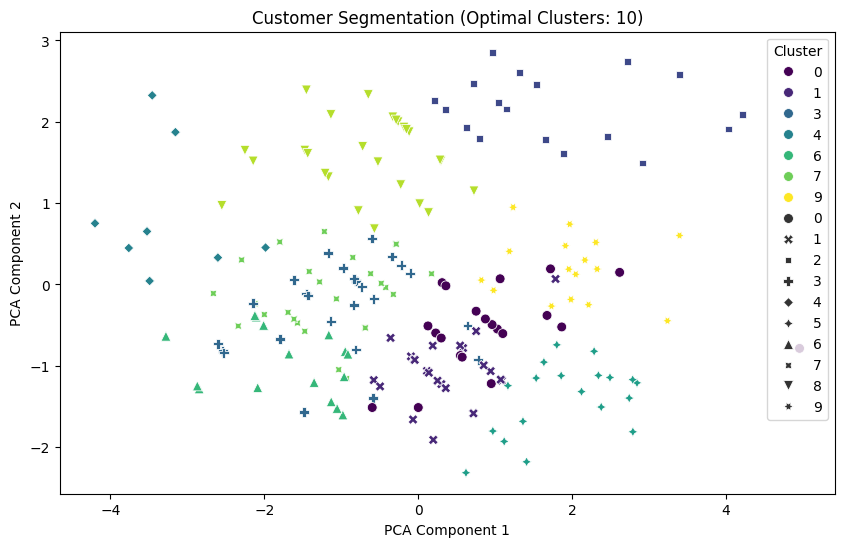

In [9]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=final_labels,
    palette="viridis",
    style=final_labels,
    s=50
)
plt.title(f"Customer Segmentation (Optimal Clusters: {best_params['n_clusters']})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Save clustering results

In [10]:
customer_data.to_csv("Customer_Segments_KMeans.csv", index=False)

# Report DB Index and other metrics

In [11]:

print(f"Best KMeans Parameters: {best_params}")
print(f"Davies-Bouldin Index: {best_db_index}")
print("Customer segmentation results saved to 'Customer_Segments_KMeans.csv'")

Best KMeans Parameters: {'init': 'random', 'max_iter': 300, 'n_clusters': 10}
Davies-Bouldin Index: 0.9963056672551005
Customer segmentation results saved to 'Customer_Segments_KMeans.csv'
